# scikit-learn regression prediction - US Health Insureance

import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


from sklearn.pipeline import make_pipeline

#dataset from https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset?resource=download
insurance_path = './insurance.csv'

## Preprocessing & Simple EDA

EDA referenced from : https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset/code?resource=download

In [ ]:
df_insurance = pd.read_csv(insurance_path)
df_insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
"""
we can identify than sex, smoker and region colums are categorical, then must be changed to numeric column
"""

le_sex = LabelEncoder()
le_smk = LabelEncoder()

le_sex.fit(df_insurance.sex.drop_duplicates())
le_smk.fit(df_insurance.smoker.drop_duplicates())

df_insurance['sex_e'] = le_sex.transform(df_insurance.sex)
df_insurance['smoker_e'] = le_smk.transform(df_insurance.smoker)

#apply OneHotEncoder to region using column transformer class

ct = ColumnTransformer(
    [('ohe', OneHotEncoder(), ['region'])],
    remainder='passthrough'
)

transformed = ct.fit_transform(df_insurance)

df_insurance = pd.DataFrame(transformed,
                            columns = ct.get_feature_names_out())

#set the new names columns
df_insurance.columns = ['region_northeast',
                        'region_northwest',
                        'region_southeast',
                        'region_southwest',
                        'age',
                        'sex',
                        'bmi',
                        'children',
                        'smoker',
                        'charges',
                        'sex_e',
                        'smoker_e']

#rearrange
df_insurance = df_insurance[['age',
                             'sex',
                             'sex_e',
                             'bmi',
                             'children',
                             'smoker',
                             'smoker_e',
                             'region_northeast',
                             'region_northwest',
                             'region_southeast',
                             'region_southwest',
                             'charges']]

In [ ]:
df_insurance_t = df_insurance[['age',
                               'sex_e',
                               'bmi',
                               'children',
                               'smoker_e',
                               'region_northeast',
                               'region_northwest',
                               'region_southeast',
                               'region_southwest',
                               'charges']]

df_insurance_t = df_insurance_t.apply(pd.to_numeric)
df_insurance_t.head()

,age,sex_e,bmi,children,smoker_e,region_northeast,region_northwest,region_southeast,region_southwest,charges
0,19,0,27.900,0,1,0.0,0.0,0.0,1.0,16884.92400
1,18,1,33.770,1,0,0.0,0.0,1.0,0.0,1725.55230
2,28,1,33.000,3,0,0.0,0.0,1.0,0.0,4449.46200
3,33,1,22.705,0,0,0.0,1.0,0.0,0.0,21984.47061
4,32,1,28.880,0,0,0.0,1.0,0.0,0.0,3866.85520


In [ ]:
fig = px.histogram(df_insurance_t,
                   nbins = 25,
                   x = 'age',
                   color='sex_e',
                   barmode='group')

fig.update_layout(title = 'Distribution of Age',
                  height = 250)

fig.show()

In [ ]:
df_insurance_t.corr()

,age,sex_e,bmi,children,smoker_e,region_northeast,region_northwest,region_southeast,region_southwest,charges
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.002475,-0.000407,-0.011642,0.010016,0.299008
sex_e,-0.020856,1.000000,0.046371,0.017163,0.076185,-0.002425,-0.011156,0.017117,-0.004184,0.057292
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,-0.138156,-0.135996,0.270025,-0.006205,0.198341
children,0.042469,0.017163,0.012759,1.000000,0.007673,-0.022808,0.024806,-0.023066,0.021914,0.067998
smoker_e,-0.025019,0.076185,0.003750,0.007673,1.000000,0.002811,-0.036945,0.068498,-0.036945,0.787251
region_northeast,0.002475,-0.002425,-0.138156,-0.022808,0.002811,1.000000,-0.320177,-0.345561,-0.320177,0.006349
region_northwest,-0.000407,-0.011156,-0.135996,0.024806,-0.036945,-0.320177,1.000000,-0.346265,-0.320829,-0.039905
region_southeast,-0.011642,0.017117,0.270025,-0.023066,0.068498,-0.345561,-0.346265,1.000000,-0.346265,0.073982
region_southwest,0.010016,-0.004184,-0.006205,0.021914,-0.036945,-0.320177,-0.320829,-0.346265,1.000000,-0.043210
charges,0.299008,0.057292,0.198341,0.067998,0.787251,0.006349,-0.039905,0.073982,-0.043210,1.000000


It seems age, smoker_e features are most correlated to charges. We will use these columns for regression.

In [ ]:
df_features = df_insurance_t[['age',
                              'smoker_e',
                              'charges']]
df_features

,age,smoker_e,charges
0,19,1,16884.92400
1,18,0,1725.55230
2,28,0,4449.46200
3,33,0,21984.47061
4,32,0,3866.85520
...,...,...,...
1333,50,0,10600.54830
1334,18,0,2205.98080
1335,18,0,1629.83350
1336,21,0,2007.94500


# Training

Using scikit-learn polynomial regerssion. We will first visualize how model predicts for each polynomial degrees.

In [ ]:
X = df_features[["age", "smoker_e"]].to_numpy()
y = np.asarray(df_features['charges'].values.tolist())

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
  return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

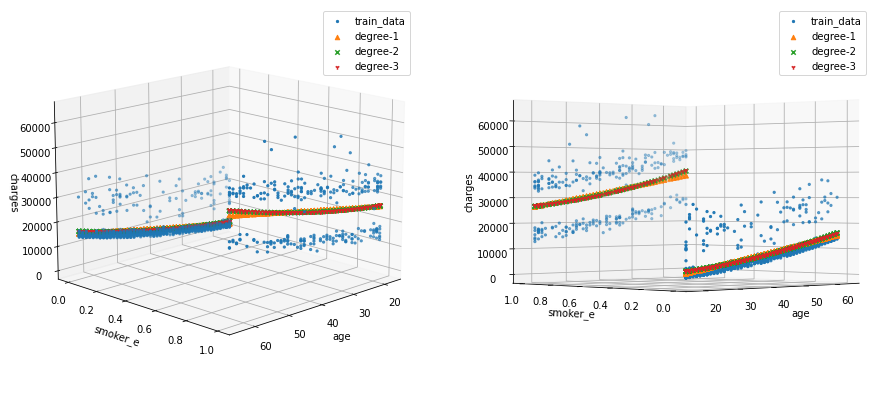

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1, projection='3d')

# ax = fig.add_subplot(projection='3d')

x_plot = np.asarray(df_features['age'].values.tolist())
y_plot = np.asarray(df_features['smoker_e'].values.tolist())
z_plot = np.asarray(df_features['charges'].values.tolist())
ax.scatter(x_plot, y_plot, z_plot, marker='.')
# ax.scatter(x_plot, y_plot, temp_result_1, marker='^')
for m, degree in [('^', 1), ('x',2), ('1',3)]:
    temp_y_test = PolynomialRegression(degree).fit(X, y).predict(X)
    ax.scatter(x_plot, y_plot, temp_y_test, marker=m)
ax.set_xlabel('age')
ax.set_ylabel('smoker_e')
ax.set_zlabel('charges')
ax.legend(['train_data', 'degree-1', 'degree-2','degree-3'])

ax.view_init(15, 45)


ax = fig.add_subplot(1, 2, 2, projection='3d')
x_plot = np.asarray(df_features['age'].values.tolist())
y_plot = np.asarray(df_features['smoker_e'].values.tolist())
z_plot = np.asarray(df_features['charges'].values.tolist())
ax.scatter(x_plot, y_plot, z_plot, marker='.')
# ax.scatter(x_plot, y_plot, temp_result_1, marker='^')
for m, degree in [('^', 1), ('x',2), ('1',3)]:
    temp_y_test = PolynomialRegression(degree).fit(X, y).predict(X)
    ax.scatter(x_plot, y_plot, temp_y_test, marker=m)
ax.set_xlabel('age')
ax.set_ylabel('smoker_e')
ax.set_zlabel('charges')
ax.legend(['train_data', 'degree-1', 'degree-2','degree-3'])

ax.view_init(0, 225)

plt.rcParams['figure.figsize'] = [15, 10] # w x h
plt.show()

We will visualize training/validation score based on each polynomial degrees.

Text(0, 0.5, 'score')

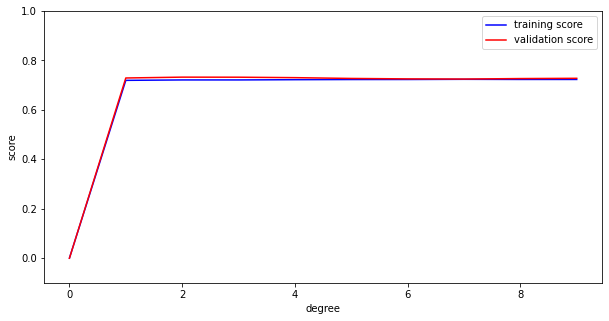

In [ ]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 10)
train_score, val_score = validation_curve(PolynomialRegression(), X, y, param_name='polynomialfeatures__degree',
                 param_range=degree)
plt.rcParams['figure.figsize'] = [10, 5] # w x h
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(-0.1, 1)
plt.xlabel('degree')
plt.ylabel('score')

Attempted to use Ridge regression model to see if it performs better.

Text(0, 0.5, 'score')

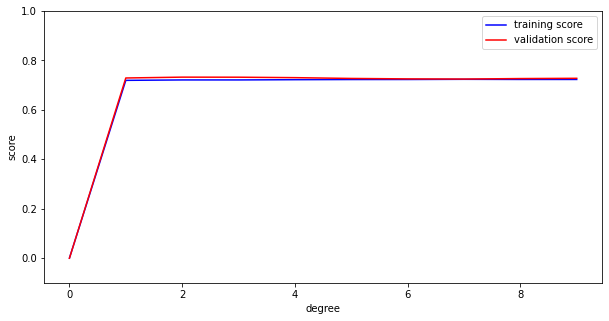

In [ ]:
from sklearn.linear_model import Ridge

degree = np.arange(0, 10)
train_scores, valid_scores = validation_curve(Ridge(), X, y, param_name="alpha", param_range=np.logspace(-7, 3, 3),cv=5)
plt.rcParams['figure.figsize'] = [10, 5] # w x h
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(-0.1, 1)
plt.xlabel('degree')
plt.ylabel('score')

Attempted with SVR, performed manual grid search and MAE is much less. Decided to use SVR after this run.

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
%%script echo skip to save time
# sample result:
    # Evaluation: Polynomial krenel
    # MAE test -> 5487.416470097448
    # Evaluation: RBF krenel
    # MAE test -> 7231.073830870748
    # Evaluation: Sigmoid krenel
    # MAE test -> 8115.8748852001545
    # Evaluation: Linear krenel
    # MAE test -> 8252.801897211664
# result: use poly

kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']#A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return SVR(kernel='poly', degree=8, gamma="auto")
    elif ktype == 1:
        # Radial Basis Function kernal
        return SVR(kernel='rbf', gamma="auto")
    elif ktype == 2:
        # Sigmoid kernal
        return SVR(kernel='sigmoid', gamma="auto")
    elif ktype == 3:
        # Linear kernal
        return SVR(kernel='linear', gamma="auto")

for i in range(len(kernels)):
    # Separate data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)# Train a SVC model using different kernal
    svclassifier = make_pipeline(StandardScaler(), getClassifier(i))
    svclassifier.fit(X_train, y_train)# Make prediction
    temp_y_pred = svclassifier.predict(X_test)# Evaluate our model
    print("Evaluation:", kernels[i], "krenel")
    pred_test = svclassifier.predict(X_test)
    mae_test = mean_absolute_error(pred_test, temp_y_pred)
    print('MAE test ->', mae_test)

skip to save time


In [ ]:
%%script echo skip to save time
# sample result:
      # Evaluation: 0 degree
      # MAE test -> 9325.86682302239
      # Evaluation: 1 degree
      # MAE test -> 7914.443756372279
      # Evaluation: 2 degree
      # MAE test -> 8799.486405310256
      # Evaluation: 3 degree
      # MAE test -> 7446.758736167864
      # Evaluation: 4 degree
      # MAE test -> 7764.548719767433
      # Evaluation: 5 degree
      # MAE test -> 7156.74127946057
      # Evaluation: 6 degree
      # MAE test -> 6480.96809070382
      # Evaluation: 7 degree
      # MAE test -> 6051.578539922704
      # Evaluation: 8 degree
      # MAE test -> 5716.516426505466
      # Evaluation: 9 degree
      # MAE test -> 5415.643463903069
      # Evaluation: 10 degree
      # MAE test -> 5652.882009425485
      # Evaluation: 11 degree
      # MAE test -> 5021.328534467777
      # Evaluation: 12 degree
      # MAE test -> 5269.842512791514
      # Evaluation: 13 degree
      # MAE test -> 5437.757324449439
      # Evaluation: 14 degree
      # MAE test -> 5518.096539703207
# result: use 11 degree
#poly for 15 degree
for i in range(15):
    # Separate data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)# Train a SVC model using different kernal
    svclassifier = make_pipeline(StandardScaler(), SVR(kernel='poly', degree=i, gamma='auto'))
    svclassifier.fit(X_train, y_train)# Make prediction
    temp_y_pred = svclassifier.predict(X_test)# Evaluate our model
    print("Evaluation:", i, "degree")
    pred_test = svclassifier.predict(X_test)
    mae_test = mean_absolute_error(pred_test, temp_y_pred)
    print('MAE test ->', mae_test)

skip to save time


In [ ]:
%%script echo skip to save time
# sample result:
      # Evaluation: 0 coef0
      # MAE test -> 5539.625249051263
      # Evaluation: 1 coef0
      # MAE test -> 4304.966913106252
      # Evaluation: 2 coef0
      # MAE test -> 3757.4880554107385
      # Evaluation: 3 coef0
      # MAE test -> 3647.9114719447916
      # Evaluation: 4 coef0
      # MAE test -> 4138.795420254355
      # Evaluation: 5 coef0
      # MAE test -> 3385.101779492287
      # Evaluation: 6 coef0
      # MAE test -> 3592.9016416940335
# result: use 5 for coef0
#poly for coef0
for i in range(6):
    # Separate data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)# Train a SVC model using different kernal
    svclassifier = make_pipeline(StandardScaler(), SVR(kernel='poly', degree=11, gamma='auto', coef0=float(i)))
    svclassifier.fit(X_train, y_train)# Make prediction
    temp_y_pred = svclassifier.predict(X_test)# Evaluate our model
    print("Evaluation:", i, "coef0")
    pred_test = svclassifier.predict(X_test)
    mae_test = mean_absolute_error(pred_test, temp_y_pred)
    print('MAE test ->', mae_test)

skip to save time


sticking with SVR

In [ ]:
# takes about 5 mins to run
regr = make_pipeline(StandardScaler(), SVR(kernel='poly', degree=11, gamma='auto', coef0=float(5)))

# actual data set for training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
regr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr',
                 SVR(coef0=5.0, degree=11, gamma='auto', kernel='poly'))])

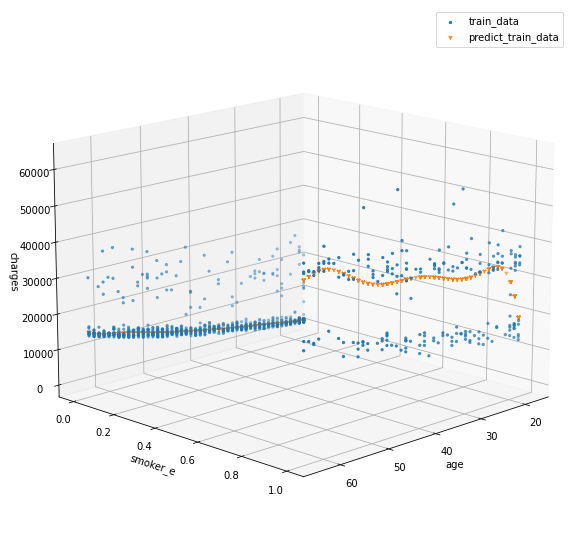

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot(projection='3d')

x_plot = np.asarray(X_train[:, 0])
y_plot = np.asarray(X_train[:, 1])
z_plot = np.asarray(y_train)
ax.scatter(x_plot, y_plot, z_plot, marker='.')
temp_y_test = regr.predict(X_train)
ax.scatter(x_plot, y_plot, temp_y_test, marker='1')
ax.set_xlabel('age')
ax.set_ylabel('smoker_e')
ax.set_zlabel('charges')
ax.legend(['train_data', 'predict_train_data'])

  
ax.view_init(15, 45)
plt.rcParams['figure.figsize'] = [15, 10] # w x h
plt.show()


# Verify & finalize model

We will use age, smoker_e feature to predict charges based on polynomial regression with degree of 3. In addition, we will also review performance in both of graph and MSE/RMSE/MAE metric.

In [ ]:
#predictions with train data
pred_train = regr.predict(X_train)

#predictions with test data
pred_test = regr.predict(X_test)

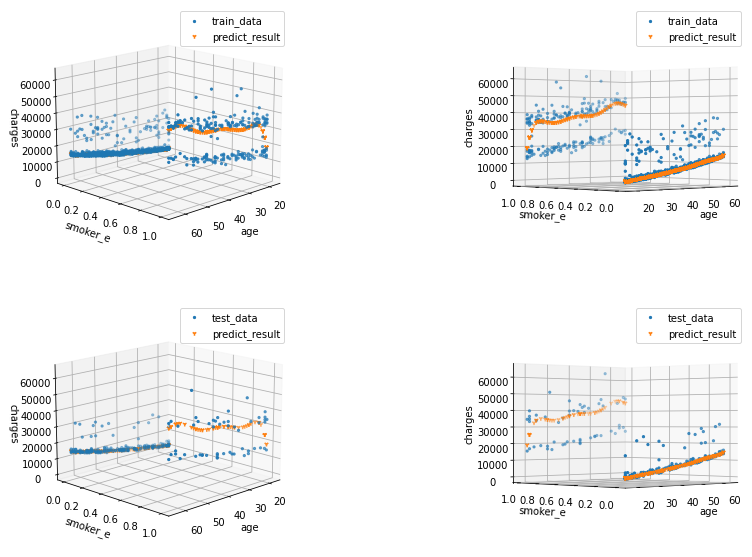

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1, projection='3d')

x_plot = np.asarray(X_train[:, 0])
y_plot = np.asarray(X_train[:, 1])
z_plot = np.asarray(y_train)
ax.scatter(x_plot, y_plot, z_plot, marker='.')
ax.scatter(x_plot, y_plot, pred_train, marker='1')
ax.set_xlabel('age')
ax.set_ylabel('smoker_e')
ax.set_zlabel('charges')
ax.legend(['train_data', 'predict_result'])

  
ax.view_init(15, 45)


ax = fig.add_subplot(2, 2, 2, projection='3d')

x_plot = np.asarray(X_train[:, 0])
y_plot = np.asarray(X_train[:, 1])
z_plot = np.asarray(y_train)
ax.scatter(x_plot, y_plot, z_plot, marker='.')
ax.scatter(x_plot, y_plot, pred_train, marker='1')
ax.set_xlabel('age')
ax.set_ylabel('smoker_e')
ax.set_zlabel('charges')
ax.legend(['train_data', 'predict_result'])

  
ax.view_init(0, 225)


ax = fig.add_subplot(2, 2, 3, projection='3d')

x_plot = np.asarray(X_test[:, 0])
y_plot = np.asarray(X_test[:, 1])
z_plot = np.asarray(y_test)
ax.scatter(x_plot, y_plot, z_plot, marker='.')
ax.scatter(x_plot, y_plot, pred_test, marker='1')
ax.set_xlabel('age')
ax.set_ylabel('smoker_e')
ax.set_zlabel('charges')
ax.legend(['test_data', 'predict_result'])

  
ax.view_init(15, 45)


ax = fig.add_subplot(2, 2, 4, projection='3d')

x_plot = np.asarray(X_test[:, 0])
y_plot = np.asarray(X_test[:, 1])
z_plot = np.asarray(y_test)
ax.scatter(x_plot, y_plot, z_plot, marker='.')
ax.scatter(x_plot, y_plot, pred_test, marker='1')
ax.set_xlabel('age')
ax.set_ylabel('smoker_e')
ax.set_zlabel('charges')
ax.legend(['test_data', 'predict_result'])

  
ax.view_init(0, 225)

plt.rcParams['figure.figsize'] = [15, 10] # w x h
plt.show()

In [ ]:
mse_train = mean_squared_error(pred_train, y_train)
sqrt_mse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(pred_train, y_train)

mse_test = mean_squared_error(pred_test, y_test)
sqrt_mse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(pred_test, y_test)

print('MSE train -> ', mse_train)
print('SQRT MSE train -> ', sqrt_mse_train)
print('MAE train ->', mae_train)

print('MSE test -> ', mse_test)
print('SQRT MSE test -> ', sqrt_mse_test)
print('MAE test ->', mae_test)

MSE train ->  47697564.92909031
SQRT MSE train ->  6906.342369814163
MAE train -> 3497.7833135023684
MSE test ->  47828710.543473616
SQRT MSE test ->  6915.830430503167
MAE test -> 3558.451862271072


# Prediction example for service

In [ ]:
test_list = [[33,1]]
test_col_names = ["age","smoker_e"]

test_df = pd.DataFrame(test_list, columns=test_col_names)

X = df_features[["age", "smoker_e"]].to_numpy()

val_est = regr.predict(X)

In [ ]:
print("cost est.:",val_est[0])

cost est.: 25449.281495869556


Side note: maybe redo with statsmodels.formula.api?